<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/lstm_%EC%9E%AC%EB%AC%B4%EC%A0%95%EB%B3%B4_%ED%98%84%EB%8C%80%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 재무지표를 포함한 lstm 종가 예측

## 라이브러리 설치

In [1]:
# 필요 라이브러리 설치
!pip install finance-datareader
!pip install pykrx

     |████████████████████████████████| 81 kB 3.9 MB/s 
     |████████████████████████████████| 60 kB 5.8 MB/s 
     |████████████████████████████████| 251 kB 16.6 MB/s 


## 패키지 로딩 및 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

  # 라이브러리를 찾음... 한방에 나옴...
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

## 데이터 로드

In [4]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
df = money_sur('005380',2018, end_date)

In [5]:
df

,Date,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
0,2018-01-02,150500,153000,149000,149500,731763,-0.041667,235358,7.43,0.64,20118,2.68,4000
1,2018-01-03,149000,151000,149000,150500,450874,0.006689,235358,7.48,0.64,20118,2.66,4000
2,2018-01-04,150500,151000,146000,146500,931558,-0.026578,235358,7.28,0.62,20118,2.73,4000
3,2018-01-05,146000,149000,145500,149000,463695,0.017065,235358,7.41,0.63,20118,2.68,4000
4,2018-01-08,148500,151000,147500,151000,482619,0.013423,235358,7.51,0.64,20118,2.65,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,2021-09-10,208500,209500,204000,206500,678308,-0.009592,250888,37.86,0.82,5454,1.45,3000
912,2021-09-13,206500,206500,204000,205000,590609,-0.007264,250888,37.59,0.82,5454,1.46,3000
913,2021-09-14,206500,211500,206000,209000,721080,0.019512,250888,38.32,0.83,5454,1.44,3000
914,2021-09-15,208000,211500,208000,209500,472855,0.002392,250888,38.41,0.84,5454,1.43,3000


## 데이터 전처리

In [6]:
df1 = df.set_index('Date')

In [7]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


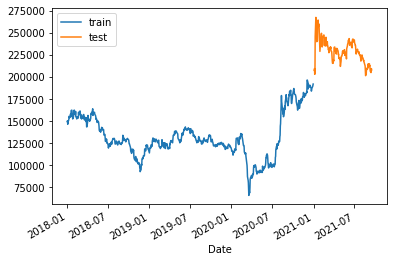

In [8]:
# test --> 21년 이후 , train --> 18~20
split_date = pd.Timestamp('01-01-2021')

train = df1.loc[:split_date, ]
test = df1.loc[split_date:, ]

ax = train['Close'].plot()
test['Close'].plot(ax=ax)
plt.legend(['train', 'test'])

In [9]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.63685015, 0.640625  , 0.64615385, ..., 1.        , 0.15880895,
        0.        ],
       [0.62538226, 0.625     , 0.64615385, ..., 1.        , 0.15384618,
        0.        ],
       [0.63685015, 0.625     , 0.62307692, ..., 1.        , 0.17121589,
        0.        ],
       ...,
       [0.93119266, 0.953125  , 0.94230769, ..., 0.39196466, 0.01736971,
        0.        ],
       [0.94648318, 0.94140625, 0.94615385, ..., 0.39196466, 0.01488832,
        0.        ],
       [0.94266055, 0.95703125, 0.95384615, ..., 0.39196466, 0.00992555,
        0.        ]])

In [10]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

In [11]:
scale_cols = list(df1.columns)

train_sc_df = pd.DataFrame(train_sc, columns=[scale_cols], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=[scale_cols], index=test.index)

In [12]:
# 종가로만 예측 시
# train_close = pd.DataFrame(train_sc_df[('Close',)])
# test_close = pd.DataFrame(test_sc_df[('Close',)])

In [13]:
for i in scale_cols:
  for s in range(1, 13):  
    train_sc_df[(i+'shift_{}'.format(s),)] = train_sc_df[(i,)].shift(s)
    test_sc_df[(i+'shift_{}'.format(s),)] = test_sc_df[(i,)].shift(s)

train_sc_df.head(13)
train_sc_df.shape

(738, 156)

In [14]:
test_sc_df.shape

(178, 156)

In [15]:
train_sc_df.columns

MultiIndex([(       'Open',),
            (       'High',),
            (        'Low',),
            (      'Close',),
            (     'Volume',),
            (     'Change',),
            (        'BPS',),
            (        'PER',),
            (        'PBR',),
            (        'EPS',),
            ...
            ( 'DPSshift_3',),
            ( 'DPSshift_4',),
            ( 'DPSshift_5',),
            ( 'DPSshift_6',),
            ( 'DPSshift_7',),
            ( 'DPSshift_8',),
            ( 'DPSshift_9',),
            ('DPSshift_10',),
            ('DPSshift_11',),
            ('DPSshift_12',)],
           length=156)

In [16]:
train_sc_df.head(13)

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Openshift_11,Openshift_12,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Highshift_11,Highshift_12,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,...,PBRshift_9,PBRshift_10,PBRshift_11,PBRshift_12,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,EPSshift_11,EPSshift_12,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DIVshift_11,DIVshift_12,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10,DPSshift_11,DPSshift_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.636850,0.640625,0.646154,0.640123,0.066660,0.237565,0.0,0.064282,0.725490,1.0,0.158809,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.625382,0.625000,0.646154,0.647779,0.032741,0.423646,0.0,0.066874,0.725490,1.0,0.153846,0.0,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.646154,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.636850,0.625000,0.623077,0.617152,0.090787,0.295629,0.0,0.056506,0.686275,1.0,0.171216,0.0,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.646154,0.646154,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.602446,0.609375,0.619231,0.636294,0.034289,0.463574,0.0,0.063245,0.705882,1.0,0.158809,0.0,0.636850,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.623077,0.646154,0.646154,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171216,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.621560,0.625000,0.634615,0.651608,0.036574,0.449559,0.0,0.068429,0.725490,1.0,0.151365,0.0,0.602446,0.636850,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.609375,0.625000,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.619231,0.623077,0.646154,0.646154,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158809,0.171216,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.640673,0.636719,0.650000,0.663093,0.034548,0.436133,0.0,0.072058,0.745098,1.0,0.143921,0.0,0.621560,0.602446,0.636850,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.609375,0.625000,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.634615,0.619231,0.623077,0.646154,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151365,0.158809,0.171216,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,0.652141,0.679688,0.669231,0.686064,0.074137,0.473607,0.0,0.079834,0.764706,1.0,0.131514,0.0,0.640673,0.621560,0.602446,0.636850,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,0.636719,0.625000,0.609375,0.625000,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,0.650000,0.634615,0.619231,0.623077,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.143921,0.151365,0.158809,0.171216,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,

In [17]:
X_train = train_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_train = train_sc_df.dropna()[['Close']]

X_test = test_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = test_sc_df.dropna()[['Close']]

X_train.head()

,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Openshift_11,Openshift_12,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Highshift_11,Highshift_12,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,Lowshift_9,Lowshift_10,Lowshift_11,Lowshift_12,Closeshift_1,Closeshift_2,Closeshift_3,Closeshift_4,...,PBRshift_9,PBRshift_10,PBRshift_11,PBRshift_12,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,EPSshift_11,EPSshift_12,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DIVshift_11,DIVshift_12,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10,DPSshift_11,DPSshift_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-18,0.686544,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.602446,0.636850,0.625382,0.636850,0.687500,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.609375,0.625000,0.625000,0.640625,0.700000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.619231,0.623077,0.646154,0.646154,0.701378,0.705207,0.682236,0.674579,...,0.705882,0.686275,0.725490,0.725490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.124069,0.121588,0.133995,0.138958,0.133995,0.131514,0.143921,0.151365,0.158809,0.171216,0.153846,0.158809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-19,0.690367,0.686544,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.602446,0.636850,0.625382,0.679688,0.687500,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.609375,0.625000,0.625000,0.684615,0.700000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.619231,0.623077,0.646154,0.682236,0.701378,0.705207,0.682236,...,0.725490,0.705882,0.686275,0.725490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.133995,0.124069,0.121588,0.133995,0.138958,0.133995,0.131514,0.143921,0.151365,0.158809,0.171216,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-22,0.671254,0.690367,0.686544,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.602446,0.636850,0.710938,0.679688,0.687500,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.609375,0.625000,0.688462,0.684615,0.700000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.619231,0.623077,0.735835,0.682236,0.701378,0.705207,...,0.745098,0.725490,0.705882,0.686275,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.106700,0.133995,0.124069,0.121588,0.133995,0.138958,0.133995,0.131514,0.143921,0.151365,0.158809,0.171216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-23,0.728593,0.671254,0.690367,0.686544,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.602446,0.726562,0.710938,0.679688,0.687500,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.609375,0.719231,0.688462,0.684615,0.700000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.619231,0.739663,0.735835,0.682236,0.701378,...,0.764706,0.745098,0.725490,0.705882,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.104218,0.106700,0.133995,0.124069,0.121588,0.133995,0.138958,0.133995,0.131514,0.143921,0.151365,0.158809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-24,0.732416,0.728593,0.671254,0.690367,0.686544,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.753906,0.726562,0.710938,0.679688,0.687500,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.738462,0.719231,0.688462,0.684615,0.700000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.728178,0.739663,0.735835,0.682236,...,0.764706,0.764706,0.745098,0.725490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.109181,0.104218,0.106700,0.133995,0.124069,0.121588,0.1

In [18]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(726, 144)
(726, 1)
(166, 144)
(166, 1)


In [19]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 12)
X_test_t = X_test.reshape(X_test.shape[0], 12, 12)

## LSTM 실행

### tensor 사용해서 window 만들기

In [ ]:
# import tensorflow as tf

# def windowed_dataset(series, window_size, batch_size, shuffle):
#     series = tf.expand_dims(series, axis=-1)
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     if shuffle:
#         ds = ds.shuffle(1000)
#     ds = ds.map(lambda w: (w[:-1], w[-1]))
#     return ds.batch(batch_size).prefetch(1)

# WINDOW_SIZE=20
# BATCH_SIZE=32

In [ ]:
# # trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
# test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# # X: (batch_size, window_size, feature)
# # Y: (batch_size, feature)
# for data in train_data.take(1):
#     print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
#     print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

### 모델

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (12, 12),
               return_sequences= True))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            19712     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 54,849
Trainable params: 54,849
Non-trainable params: 0
_________________________________________________________________


In [22]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 30번 epoch통안 val_loss 개선이 없다면 학습 중지
earlystopping = EarlyStopping(monitor='val_loss', patience=30)
# val_loss 기준 체크포인터도 생성
filename = 'lstm_hundai.h5'
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [23]:
history = model.fit(X_train_t, y_train, validation_data=(X_test_t,y_test),
                    epochs=300, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/300
23/23 [==============================] - 9s 51ms/step - loss: 0.0248 - mse: 0.0496 - val_loss: 0.1524 - val_mse: 0.3048

Epoch 00001: val_loss improved from inf to 0.15242, saving model to lstm_hundai.h5
Epoch 2/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0074 - mse: 0.0148 - val_loss: 0.0923 - val_mse: 0.1846

Epoch 00002: val_loss improved from 0.15242 to 0.09231, saving model to lstm_hundai.h5
Epoch 3/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0057 - mse: 0.0114 - val_loss: 0.0585 - val_mse: 0.1171

Epoch 00003: val_loss improved from 0.09231 to 0.05854, saving model to lstm_hundai.h5
Epoch 4/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0044 - mse: 0.0088 - val_loss: 0.0276 - val_mse: 0.0553

Epoch 00004: val_loss improved from 0.05854 to 0.02764, saving model to lstm_hundai.h5
Epoch 5/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0033 - mse: 0.0066 - val_loss: 0.0098 - val_mse:

In [24]:
X_test_t

array([[[ 1.35168196e+00,  1.30198777e+00,  1.41284404e+00, ...,
          1.08792049e+00,  1.06880734e+00,  9.69418960e-01],
        [ 1.48828125e+00,  1.37109375e+00,  1.43750000e+00, ...,
          1.09765625e+00,  1.10937500e+00,  1.09375000e+00],
        [ 1.37692308e+00,  1.30000000e+00,  1.33846154e+00, ...,
          1.05769231e+00,  1.07692308e+00,  9.88461538e-01],
        ...,
        [ 3.91964656e-01,  3.91964656e-01,  3.91964656e-01, ...,
          3.91964656e-01,  3.91964656e-01,  3.91964656e-01],
        [-1.26550860e-01, -9.42927979e-02, -9.18114108e-02, ...,
         -1.73697096e-02, -3.22580617e-02, -2.72952875e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.55810398e+00,  1.35168196e+00,  1.30198777e+00, ...,
          1.06116208e+00,  1.08792049e+00,  1.06880734e+00],
        [ 1.60937500e+00,  1.48828125e+00,  1.37109375e+00, ...,
          1.08984375e+00,  1.09765625e

In [25]:
model.load_weights(filename)
pred = model.predict(X_test_t)

In [26]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [27]:
pred.shape

(166, 1)

In [28]:
test_ttt = test['Close'][-2]

In [29]:
pred_act = reverse_min_max_scaling(test_ttt, pred[-2])

In [30]:
pred_act.shape

(1,)

In [31]:
pred_act, test_ttt

(array([209500.0000001]), 209500)

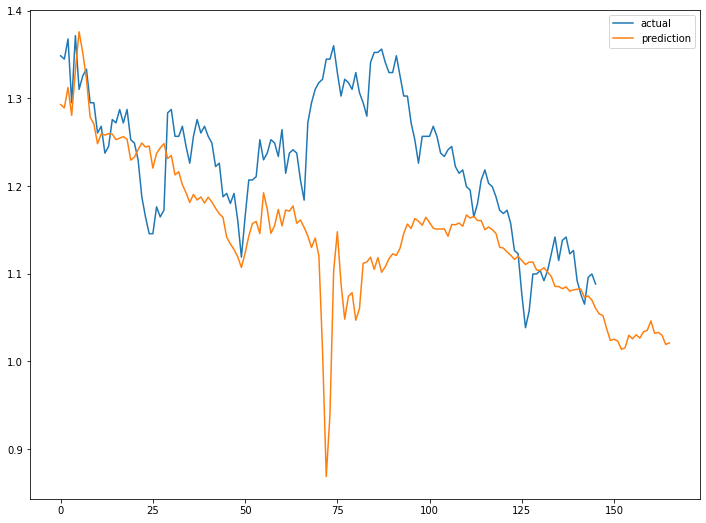

In [32]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [33]:
score = model.evaluate(X_test_t,y_test,batch_size=30)
print(score)

6/6 [==============================] - 0s 6ms/step - loss: 0.0075 - mse: 0.0149
[0.007464225869625807, 0.014928451739251614]


In [34]:
test_sc_df[('Close',)].describe()

count    178.000000
mean       1.253218
std        0.100917
min        1.038285
25%        1.187596
50%        1.254594
75%        1.321593
max        1.543645
Name: (Close,), dtype: float64

In [35]:
pd.DataFrame(pred).describe()

,0
count,166.000000
mean,1.143259
std,0.080349
min,0.868512
25%,1.097893
50%,1.145831
75%,1.180974
max,1.375728


Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


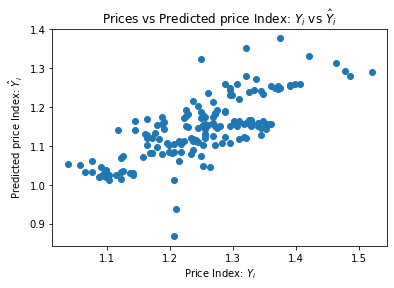

In [36]:
# 직선에 가까울 수록 정확도가 높다
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")